In [41]:
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

In [50]:
class MultiGridSolver2D:
    
    """
    General 2D Geometric Multigrid solver for Dirichlet BC posed in form Ax=b. 
    Capabilities: Any static problem, assuming the above conditions are satisfied. 
                  Time-dependent is enabled as well. Boundary conditions must be dealt with beforehand.              
    Restrictions: The mesh must be square.
                  The number of fine-mesh points must be odd. 
                  Higher accuracy/faster convergence follows from using a dimension 2^n+1
    
    """
    
    def __init__(self, construct_A, b, x0, dim, max_grids=10, iter_max=25):
        """
        Constructor
        Inputs: 
            construct_A: A function to discretize the linear operator over any desired mesh WITHOUT BC.
            It must take in a single mesh direction
            b: Vector of field WITHOUT BC for Ax=b but accounted for (the way RDAY 18 PC does).
            x0: Initial solution guess WITH BC. The BC are fixed
            dim: The number of points in a single dimension (including the BC)
            max_grids: The number of grids utilized for coursening (including the fine grid)
            iter_max: Number of Jacobi relaxations on each grid
        """
        self.construct_A = construct_A 
        self.A = self.construct_A(dim-2) # A is only needed for interior points of mesh
        self.b = b.flatten()
        self.max_grids = max_grids
        self.dim = dim
        self.iter_max = iter_max
        self.x0 = x0.reshape(dim,dim)
        self.current_grid = 1
     
    def next_dim(self, current_dim):
        """
        shortcut to determine next grid length
        """
        return int((current_dim-1)/2)
    
    def construct_A_wrapper(self, n):
        """
        Wrapper func for user specified function that constructs the linear operator on a mesh
        """
        return self.construct_A(n)
    
    def solve(self, cycle_count=1):
        """
        Wrapper for solve function
        """
        x_solved = self.x0.copy()
        
        for i in range(cycle_count):
            
            # we can't change the boundary but we can pose the problem as if error is zero on boundaries
            x_solved[1:-1,1:-1] = self.v_cycle(self.A, self.b, x_solved[1:-1,1:-1].flatten(), self.dim-2).copy()
        
        return x_solved
    
    def v_cycle(self, A_h, b_h, x0_h, dim):
        
        """
        This function is a recursive V-cycle multigrid solver. 
        Notes: The '_h' at the end of the variables denotes resolution; 2h is 2x coarser than h (in each dim).
        'dim' means the length of a side WITH boundary conditions
        """
        
        # base case: Either at the coursest grid specified or we are at the coursest grid possible
        if(self.current_grid==self.max_grids or dim%2==0 or dim==1):
            x_base = x0_h.reshape(dim, dim)
            
            # Solve on the coursest grid via relaxation.
            x_base = self.weighted_jacobi(inA=A_h, inb=b_h, 
                                                         x0=x_base.flatten(),
                                                         iter_max=self.iter_max).reshape(dim,dim)
            return x_base
        
        else:
            self.current_grid += 1
            
            # Relax on current grid
            x_soln = x0_h.reshape(dim, dim).copy()
            x_soln = self.weighted_jacobi(inA=A_h, inb=b_h, 
                                                         x0=x_soln.flatten(),
                                                         iter_max=self.iter_max).reshape(dim,dim)
            # Compute residual after relaxation
            r_h = b_h - np.matmul(A_h, x_soln.flatten())
            
            next_dim = self.next_dim(dim)
            
            # Solve for the error recursively 
            A_2h, r_2h = self.coursen(A_h, r_h, dim)
            e_2h = 0*r_2h.copy() # Initial guess just needs to be the zero vector
            e_2h = self.v_cycle(A_2h, r_2h, e_2h, dim=next_dim)

            # Correct the current grid with interpolated error from the previous grid
            x_soln = self.interpolate(e_2h.reshape(next_dim,next_dim)) + x_soln
            
            # Post-smoothing: relaxing again can be very effective if iter_max is very low (eg. 1-3)
            x_soln = self.weighted_jacobi(inA=A_h, inb=b_h,
                                          x0=x_soln.flatten(),
                                          iter_max=self.iter_max).reshape(dim,dim)
            return x_soln
    
    def coursen(self, A_h, r_h, dim):
        """
        Input: The linear operator and the residual on the finer grid.
        Returns: The coursened version of the inputs for the next courser grid.
        """
        r_h = r_h.reshape(dim,dim).copy()
        r_2h = np.zeros((self.next_dim(dim), self.next_dim(dim)))
        A_2h = self.construct_A_wrapper(self.next_dim(dim)) # rediscretize operator on courser grid
        
        # Full weighting to project residual onto courser grid. 
        # Injection is a less effective version (although cheaper)
        for i in range(r_2h.shape[0]):
            for j in range(r_2h.shape[0]):
                
                # Calculate the indices of the corresponding fine grid points
                fi = int(2*i+1)
                fj = int(2*j+1)
                indices = [(fi-1, fj-1), (fi-1, fj), (fi-1, fj+1),
                           (fi, fj-1),   (fi, fj),   (fi, fj+1),
                           (fi+1, fj-1), (fi+1, fj), (fi+1, fj+1)]

                # Stencil for weighting
                weights = np.array([1/16, 1/8, 1/16,
                                    1/8, 1/4, 1/8,
                                    1/16, 1/8, 1/16])
                
                r_h_values = np.zeros(9)
                for k, (fx, fy) in enumerate(indices):
                    r_h_values[k] = r_h[fx,fy]

                # Calculate the coarsened value as a weighted sum of the fine grid values
                r_2h[i,j] = np.dot(weights, r_h_values.flatten())
        return A_2h, 4*r_2h.flatten()
    
    def interpolate(self, e_2h):
        """
        Input: The course error
        Returns: The interpolated error onto a mesh 2x finer. 
        Assuming error is 0 on boundaries is why we can use the interpolation matrix
        """
        dim = e_2h.shape[0]
        I_2h_to_h = self.interpolation_matrix(dim) # interpolation matrix
        e_h = np.zeros((I_2h_to_h.shape[0],I_2h_to_h.shape[0]))    
        
        # temporary h x 2h matrix to hold interpolated rows before cols have been treated
        temp_h = np.zeros((dim,e_h.shape[0])) 
        
        # interpolation in rows first
        for i in range(0,e_h.shape[0]-1,2):
            interp_row = np.matmul(I_2h_to_h, e_2h[int(i/2)])
            temp_h[int(i/2)] = interp_row.copy()
        
        # interpolate cols of the current fat-short matrix to obtain fully interpolated field 
        for i in range(0,e_h.shape[0],1):
            interp_col = np.matmul(I_2h_to_h, temp_h[:,i])
            e_h[:,i] = interp_col.copy()
            
        return e_h
            
    def interpolation_matrix(self, n):
        """
        When used on a 1D vector, it performs linear interpolation to map n-vector to (n*2+1)-vector
        n must be odd. Bilinear (2D) interpolation comes from sweeping in each direction sequentially.
        """
        I = np.zeros((2*n+1, n))
        for i in range(n):
            I[2*i:2*i+3,i] = [0.5,1,0.5]
        return I 
    
    def weighted_jacobi(self, inA, inb, x0=None, iter_max=10):
        """
        Weighted jacobi exhibits faster convergence when the weight is chosen well.
        """
        inb = inb.flatten()
        n = inA.shape[0]
        if x0 is None:
            x0 = np.zeros(n)
        else: 
            x0 = x0.flatten()

        w = 4.0/5 # weight factor
        x = x0.copy()
        x_new = np.zeros_like(x)
        for it in range(iter_max):
            for i in range(n):
                x_new[i] = (1 - w) * x[i] + w / inA[i, i] * (inb[i] - inA[i, :].dot(x) + inA[i, i] * x[i])
            x = x_new.copy()
        return x

In [51]:
def finite_difference_matrix_2D(n):
    """
    The tridiagonal matrix of 2D 2nd degree finite difference. Used to construct operator
    """
    L = np.zeros([n,n])
    for i in range(n):
        L[i,i] = -4
        if(i<n-1):
            L[i,i+1] = 1
            L[i+1,i] = 1
    return L

def construct_A(n):
    """
    The Laplace operator. It has a tri-block-diagonal structure with FD matrix on diagonal
    and identity on off diagonal.
    """
    A = np.zeros([n**2,n**2])
    L = finite_difference_matrix_2D(n)
    I = np.identity(n)
    for i in range(n):
        A[i*n:(i+1)*n, i*n:(i+1)*n] = L
        if(i<n-1):
            A[i*n:(i+1)*n, (i+1)*n:(i+2)*n] = I
            A[(i+1)*n:(i+2)*n, i*n:(i+1)*n] = I
    return A

# will plot a slice of the mesh of the temperature 
def plotDomain(mesh):
    pos = plt.imshow(mesh,
              extent =[-1, 1, -1, 1],
              interpolation='nearest', cmap='rainbow', origin ='lower')
    plt.xlabel('Y', fontweight="bold",fontsize=14)
    plt.ylabel('X', fontweight="bold",fontsize=14)
    plt.title("Temperature Field", fontweight="bold", fontsize=20)
    plt.grid(color = 'white',which='major', alpha=0.5)
    plt.grid(color = 'white',which='minor', alpha=0.2)
    plt.colorbar(pos)

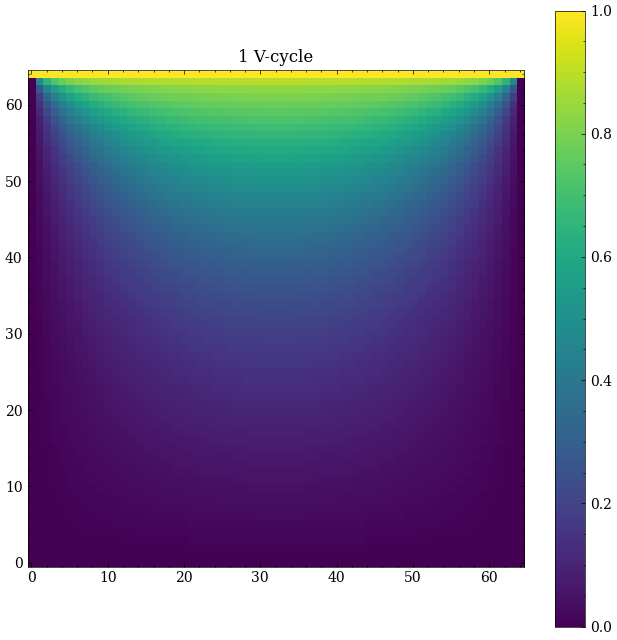

Initial Residual Norm 7.937253933193772
After one V-cycle (3 jacobi per level):  0.45291973864478446


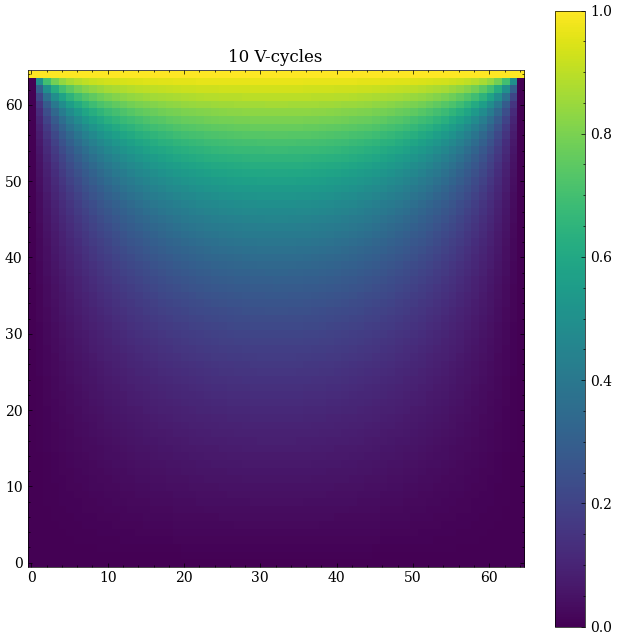

Initial Residual Norm 7.937253933193772
After one V-cycle (3 jacobi per level):  0.008986362886906879


In [52]:
# Dimension, potential, target convergence 
M = 65         # Side length/n_points, must be odd!!!
V = 1.0         # Potential source strength

# x0 = grid, set boundary condition for potential source
x0 = np.zeros([M,M],float)
x0[-1,:] = V
b = np.zeros_like(x0[1:-1, 1:-1])

# move Dirichlet boundary conditions to b to avoid interfering with it
#b[M-3] = b[M-3] - x0[M-1,1:-1]

b[-1] = b[-1] - x0[-1,1:-1]
b[0] = b[0] - x0[0,1:-1]
b[:,-1] = b[:,-1] - x0[1:-1,-1]
b[:,0] = b[:,0] - x0[1:-1,0]
A = construct_A(M-2)
iter_max = 3

"""Demonstration for single V-cycle"""
MGS = MultiGridSolver2D(construct_A, b, x0, dim=M, iter_max=iter_max)
x = MGS.solve()
fig = plt.figure(figsize=(8,8))
s = plt.imshow(x, origin='lower')
plt.title("1 V-cycle")
plt.colorbar(s)
plt.show()
print("Initial Residual Norm", np.linalg.norm(b.flatten() - A@x0[1:-1,1:-1].flatten()))
print("After one V-cycle (%i jacobi per level): "%iter_max, np.linalg.norm(b.flatten()-A@x[1:-1,1:-1].flatten()))


"""Multiple V-cycles"""
MGS = MultiGridSolver2D(construct_A, b, x0, dim=M, iter_max=iter_max)
x = MGS.solve(10)
fig = plt.figure(figsize=(8,8))
s = plt.imshow(x, origin='lower')
plt.title("10 V-cycles")
plt.colorbar(s)
plt.show()
print("Initial Residual Norm", np.linalg.norm(b.flatten() - A@x0[1:-1,1:-1].flatten()))
print("After one V-cycle (%i jacobi per level): "%iter_max, np.linalg.norm(b.flatten()-A@x[1:-1,1:-1].flatten()))

In [45]:
import numpy as np
from numpy import empty, zeros, max, copy
from pylab import imshow, gray, show
import matplotlib.pyplot as plt
import time 

# Modified from RDAY-PC 18
def jacobi_laplace(tol):
    # Dimension, potential, target convergence 
    M = 65          # Side length/n_points
    V = 1.0         # Potential source strength

    # phi = grid, set boundary condition for potential source
    phi = zeros([M+1,M+1],float)
    phi[M,:] = V
    phinew = copy(phi)

    st = time.time()
    # iteration loop 
    delta = 100
    while delta > tol:
    
        # update each value of the grid based on adjacent values. Don't touch boundaries
        for i in range(1,M):
            for j in range(1,M):
                phinew[i,j] = (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4

        # compute residual between iterations
        delta = np.linalg.norm((phi-phinew))

        # set new iterations 
        phi, phinew = phinew, phi
    end = time.time()
    return phinew, (end-st)

def multigrid_laplace(it):
    # Dimension, potential, target convergence 
    M = 65         # Side length/n_points, must be odd!!!
    V = 1.0         # Potential source strength

    # x0 = grid, set boundary condition for potential source
    x0 = np.zeros([M,M],float)
    x0[-1,:] = V
    b = np.zeros_like(x0[1:-1, 1:-1])
    iter_max = 10
    # move Dirichlet boundary conditions to b to avoid interfering with it
    #b[M-3] = b[M-3] - x0[M-1,1:-1]

    b[-1] = b[-1] - x0[-1,1:-1]
    b[0] = b[0] - x0[0,1:-1]
    b[:,-1] = b[:,-1] - x0[1:-1,-1]
    b[:,0] = b[:,0] - x0[1:-1,0]
    A = construct_A(M-2)
    #iter_max = 3

    """Iterated V-cycles"""
    st = time.time()
    MGS = MultiGridSolver2D(construct_A, b, x0, dim=M, iter_max=it)
    x = MGS.solve(10)
    end = time.time()
    # return largest error, time taken 
    return np.linalg.norm(b.flatten()-A@x[1:-1,1:-1].flatten()), (end-st)

In [31]:
it_arr = np.linspace(1,30, 5)
tol_arr = []
multigrid_t_arr = []
jacobi_t_arr = []
for it in it_arr:
    tol, t = multigrid_laplace(int(it))
    multigrid_t_arr.append(t)
    tol_arr.append(tol)
    _,jac_t = jacobi_laplace(tol)
    jacobi_t_arr.append(jac_t)
    

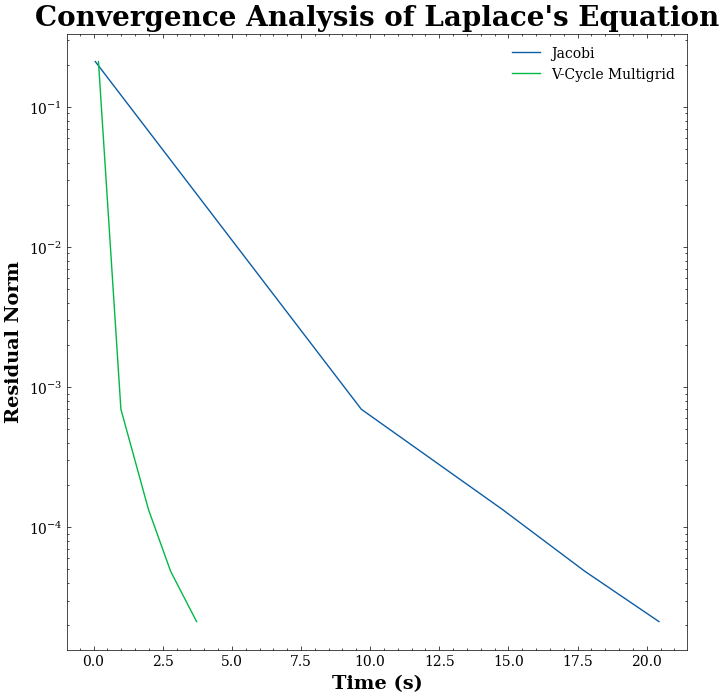

In [38]:
fig = plt.figure(figsize=(8,8))
plt.xlabel('Time (s)', fontweight="bold",fontsize=14)
plt.ylabel('Residual Norm', fontweight="bold",fontsize=14)
plt.title("Convergence Analysis of Laplace's Equation", fontweight="bold", fontsize=20)
plt.grid(color = 'white',which='major', alpha=0.5)
plt.grid(color = 'white',which='minor', alpha=0.2)
plt.plot(jacobi_t_arr, tol_arr, label='Jacobi')
plt.plot(multigrid_t_arr, tol_arr, label='V-Cycle Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

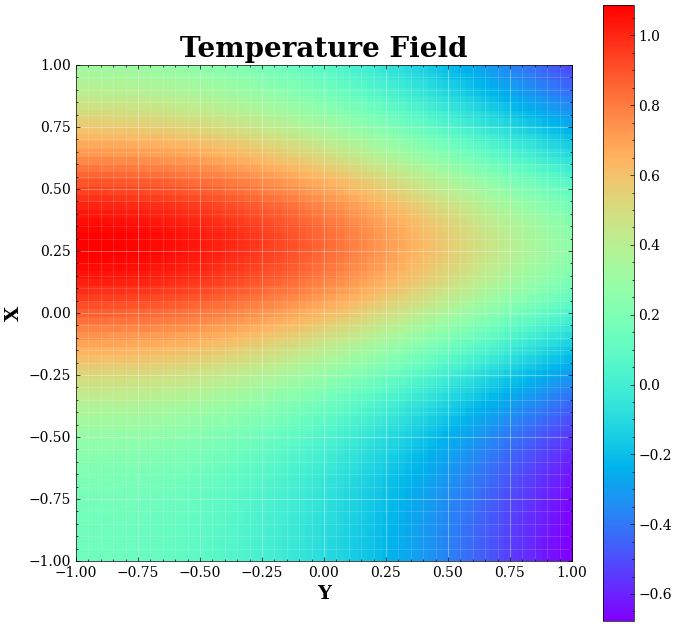

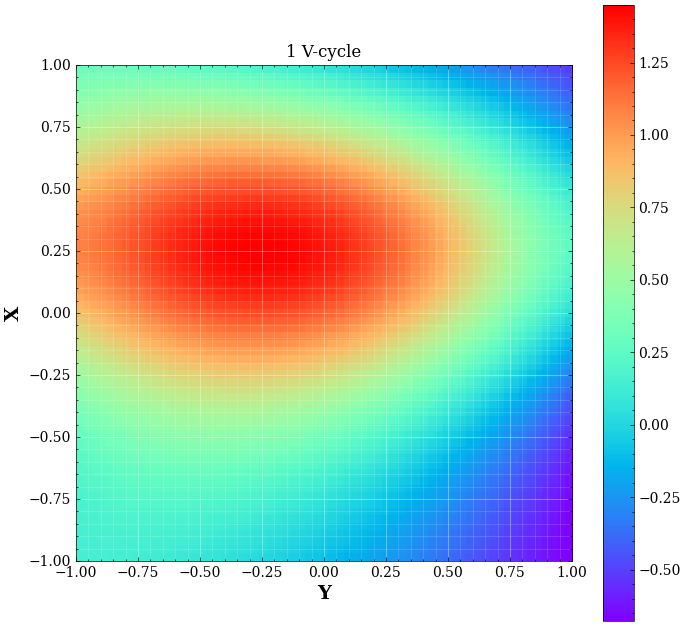

Initial Residual Norm 4.044072055324643
After one V-cycle (3 jacobi per level):  21.504758208740775


In [53]:
"""Time Dependent Heat Equation"""

# Dimension, potential, target convergence 
M = 65         # Side length/n_points, must be odd!!!
dl = 1.0/M
dt = 1
alpha = 0.005
bc_factor = alpha*dt*(M**2)

# function to assign initial temperature values to points on mesh
def initialT(x,y,dx):
    x *= dx
    y *= dx
    return 0.4*np.exp(-1*np.cos(5*x)) - np.sin(y**2)

def construct_L(n):
    A = construct_A(n)
    I = np.identity(A.shape[0])
    L = I - bc_factor*A
    return L
    
# assigning mesh values for initial snapshot
T0 = np.zeros([M, M])
for x in range(T0.shape[0]):
    for y in range(T0.shape[1]):
        T0[x,y] = initialT(x,y, dl)

fig = plt.figure(figsize=(8,8))
plotDomain(T0)
plt.show()
iter_max = 3


T1 = T0.copy()
#T1[1:-1,1:-1] = 0

# move Dirichlet boundary conditions to b to avoid interfering with it
b =  T0[1:-1, 1:-1].copy()
b[-1] += T1[-1,1:-1]*bc_factor
b[0] += T1[0,1:-1]*bc_factor
b[:,-1] += T1[1:-1,-1]*bc_factor
b[:,0] += T1[1:-1,0]*bc_factor

L = construct_L(M-2)

#Demonstration for single V-cycle
MGS = MultiGridSolver2D(construct_L, b, T1, dim=M, iter_max=iter_max)
x = MGS.solve(30)
fig = plt.figure(figsize=(8,8))
plotDomain(x)
plt.title("1 V-cycle")
plt.show()
print("Initial Residual Norm", np.linalg.norm(b.flatten() - L@T1[1:-1,1:-1].flatten()))
print("After one V-cycle (%i jacobi per level): "%iter_max, np.linalg.norm(b.flatten()-L@x[1:-1,1:-1].flatten()))

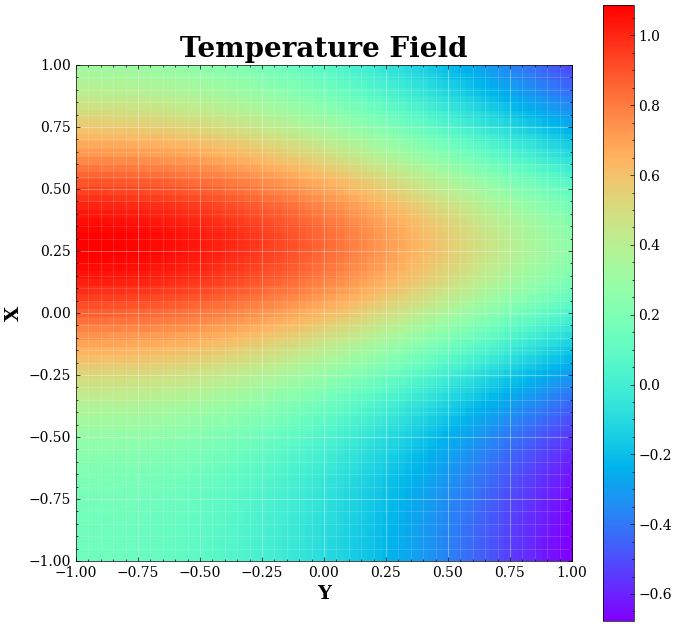

In [54]:
"""Time Dependent Heat Equation"""

# Dimension, potential, target convergence 
M = 65         # Side length/n_points, must be odd!!!
dl = 1.0/M
dt = 0.05
bc_factor = alpha*dt*(M**2)
iter_max = 3


# function to assign initial temperature values to points on mesh
def initialT(x,y,dx):
    x *= dx
    y *= dx
    return 0.4*np.exp(-1*np.cos(5*x)) - np.sin(y**2)

def construct_L(n):
    A = construct_A(n)
    I = np.identity(A.shape[0])
    L = I - A*bc_factor
    return L
    
# assigning mesh values for initial snapshot
T0 = np.zeros([M, M])
for x in range(T0.shape[0]):
    for y in range(T0.shape[1]):
        T0[x,y] = initialT(x,y, dl)

fig = plt.figure(figsize=(8,8))
plotDomain(T0)
plt.show()
iter_max = 3

#T1[1:-1,1:-1] = 0

L = construct_L(M-2)

field_traj = np.empty([100,65,65])
field_traj[0] = T0

for i in range(1,100):
    # move Dirichlet boundary conditions to b to avoid interfering with it
    T1 = field_traj[i-1].copy()
    b =  field_traj[i-1, 1:-1, 1:-1].copy()
    b[-1] += T1[-1,1:-1]*bc_factor
    b[0] += T1[0,1:-1]*bc_factor
    b[:,-1] += T1[1:-1,-1]*bc_factor
    b[:,0] += T1[1:-1,0]*bc_factor
    
    MGS = MultiGridSolver2D(construct_L, b, T1, dim=M, iter_max=iter_max)
    T0 = MGS.solve(10)
    field_traj[i] = T0.copy()
    #plotDomain(T0)
    #plt.show()

In [55]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, (ax1) = plt.subplots(figsize=(12,6), ncols=1)
major_ticks = np.arange(-1, 1.2, 0.4)
minor_ticks = np.arange(-1, 1.05, 0.1)

def animate(i):
    x = int(i*5)
    pred = field_traj[x]
    pos = ax1.imshow(pred,
              extent =[-1, 1, -1, 1],
              interpolation='nearest', cmap='rainbow', origin ='lower')


    ax1.set_xlabel("Y", fontweight="bold",fontsize=14)
    ax1.set_ylabel("X", fontweight="bold",fontsize=14)
    ax1.set_title("Multigrid Solution", fontweight="bold",fontsize=20)

    ax1.set_yticks(major_ticks)
    ax1.set_xticks(minor_ticks, minor=True)
    ax1.set_yticks(minor_ticks, minor=True)
    ax1.grid(color = 'white',which='major', alpha=0.5)
    ax1.grid(color = 'white',which='minor', alpha=0.2)
    plt.close()

ani = FuncAnimation(fig, animate, frames=20, interval=100, repeat=False)
HTML(ani.to_jshtml())

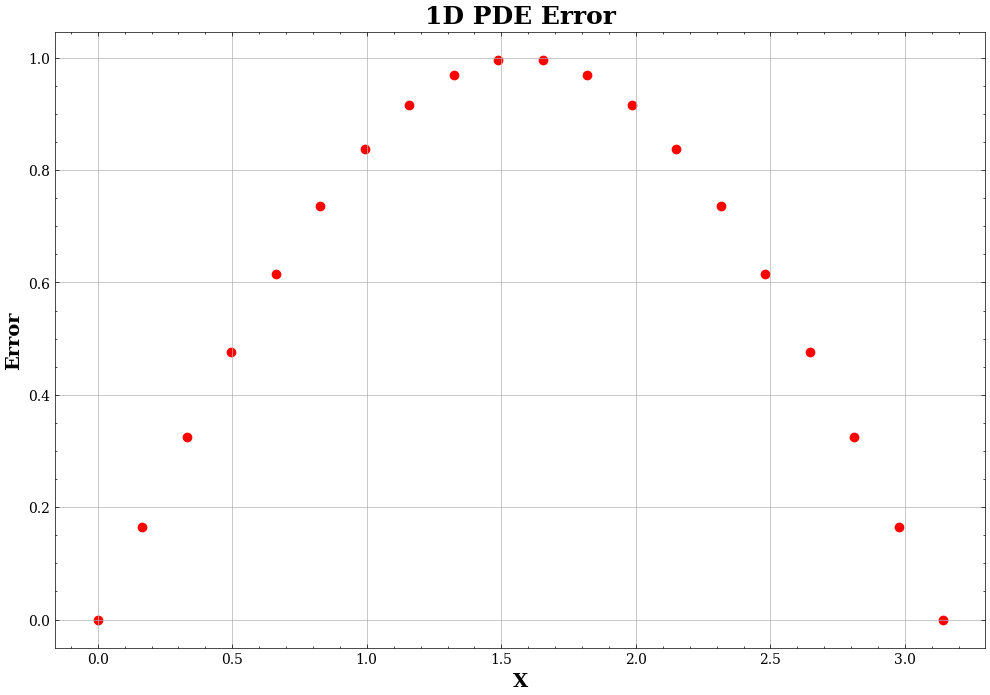

In [40]:
x = np.linspace(0, np.pi,20)
plt.figure(figsize=(12,8))
plt.scatter(x, np.sin(x), color='red')
plt.ylabel("Error", fontsize=14, fontweight='bold', )
plt.xlabel("X", fontsize=14, fontweight='bold', )
plt.title("1D PDE Error", fontweight='bold', fontsize=18)
plt.grid()